## Ré-échantillonage

In [2]:
import os
import argparse
import torch as th
import torch.nn.functional as F
import time
import conf_mgt
from utils import yamlread
from guided_diffusion import dist_util
from tqdm import tqdm
# Workaround
try:
    import ctypes
    libgcc_s = ctypes.CDLL('libgcc_s.so.1')
except:
    pass


from guided_diffusion.script_util import (
    NUM_CLASSES,
    model_and_diffusion_defaults,
    classifier_defaults,
    create_model_and_diffusion,
    create_classifier,
    select_args,
)  # noqa: E402

from guided_diffusion.script_util import (
    sr_model_and_diffusion_defaults,
    sr_create_model_and_diffusion,
)
def toU8(sample):
    if sample is None:
        return sample

    sample = ((sample + 1) * 127.5).clamp(0, 255).to(th.uint8)
    sample = sample.permute(0, 2, 3, 1)
    sample = sample.contiguous()
    sample = sample.detach().cpu().numpy()
    return sample

import torch
import torchvision.transforms as T

In [3]:
intermediate_steps = False #return intermediate results (usefull to create gifs, but will use lot of memory - around 3GB for one 256x256 image)
conf = conf_mgt.conf_base.Default_Conf()
conf.update(yamlread('confs/my_conf-2.yml'))
print(conf.inpa_inj_sched_prev) #Are you about to use RePainting ?print(conf.diffusion_steps) #may not be the good one
conf.intermediate_steps = intermediate_steps
print(conf.intermediate_steps)


True
False


In [4]:
print("Start", conf['name'])

device = dist_util.dev(conf.get('device'))


model, diffusion = create_model_and_diffusion(
    **select_args(conf, model_and_diffusion_defaults().keys()), conf=conf
)


Start my_conf


In [4]:
model.load_state_dict(
    dist_util.load_state_dict(os.path.expanduser(
        conf.model_path), map_location="cpu")
)
model.to(device)
if conf.use_fp16:
    model.convert_to_fp16()
model.eval()

show_progress = conf.show_progress

import numpy as np
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print('Nombre de paramètres : ', params)

Nombre de paramètres :  552814086


In [ ]:
# https://colab.research.google.com/drive/12a_Wrfi2_gwwAuN3VvMTwVMz9TfqctNj#scrollTo=7zAqFEykBHDL TO DO

In [5]:

cond_fn = None

def model_fn(x, t, y=None, gt=None, **kwargs):
    assert y is not None
    return model(x, t, y if conf.class_cond else None, gt=gt)

In [6]:
dset = 'eval'

eval_name = conf.get_default_eval_name()

IMAGE_SIZE = 256
GT_PATH = './data/datasets/gts/dogs'
MASK_PATH = './data/datasets/gt_keep_masks/genhalf'
dataconfig = {'mask_loader': True,
 'gt_path': GT_PATH,
 'mask_path': MASK_PATH,
 'image_size': IMAGE_SIZE,
 'class_cond': False,
 'deterministic': True, # Pas de shuffle dans le dataloader
 'random_crop': False, # Crop (au lieu de redimensionner l'image). Non Implémenté.
 'random_flip': False,
 'return_dict': True,
 'drop_last': False,
 'batch_size': 1,
 'return_dataloader': True,
 'offset': 0,
 'max_len': None,
 'paths': {'srs': './log/face_example/inpainted',
  'lrs': './log/face_example/gt_masked',
  'gts': './log/face_example/gt',
  'gt_keep_masks': './log/face_example/gt_keep_mask'}
             }

conf['data']['eval'][eval_name] = dataconfig

return_all = True
conf.intermediate_steps = False
path_save_checkpoint = './data/datasets/gts/dogs/checkpoints/'
path_save_finals = './inpainted/dogs/finals/'
path_save_resamples = './inpainted/dogs/from_checkpoint/'
format_save = '.png'
transform = T.ToPILImage()
def tou8batch(result,return_all=False):
    if return_all:
        finals = result[1]['sample']
    else:
        finals = result
    finals = ((finals + 1) * 127.5).clamp(0, 255).to(th.uint8)
    finals = finals.contiguous()
    return(finals)

In [7]:
from guided_diffusion.scheduler import get_schedule_jump
from matplotlib import pyplot as plt
import numpy as np


if conf.schedule_jump_params:
            times = get_schedule_jump(**conf.schedule_jump_params)

            time_pairs = list(zip(times[:-1], times[1:]))
            time_pairs = np.array(time_pairs)
            allowed = [0 if i[0]<i[1] else 1 for i in time_pairs]
            
to_save = (190*np.array(range(23))+200) #Indexes of steps we want to save. It is every 10 diffusion reverse, for conf jump : 250,10,10.

In [16]:
#Initialize folder structure and copy generated sample

import blobfile as bf
import shutil

originals_path =  './data/datasets/gts/dogs/'

images = np.array(sorted(bf.listdir(path_save_finals)))
samples_unique = np.unique([i[:6] for i in images])
for folder_name in samples_unique:
    path = path_save_resamples+folder_name
    if not os.path.exists(path):
        os.mkdir(path)
    samples = np.array(images)[[folder_name in i for i in images]]
    samples = [i[:-4] for i in samples]
    for i in samples:
        path_i = path+'/'+i
        path_img_i = path_save_finals+i+format_save
        if not os.path.exists(path_i):
            os.mkdir(path_i)
            shutil.copy(path_img_i, path_i)
        shutil.copy(originals_path + folder_name + '.jpg',path_i)

In [23]:
dl = conf.get_dataloader(dset=dset, dsName=eval_name)

In [58]:
from natsort import os_sorted


In [24]:

for batch in iter(dl):
    img = batch['GT'].to(device)
    mask = batch['gt_keep_mask'].to(device)

    name = batch['GT_name'][0][:-4]
    samples = np.array(images)[[name in i for i in images]]
    samples = [i[:-4] for i in samples] #get list of samples generated with this image
    samples = os_sorted(samples)[:3] #taking only 3 samples from each images
    print(samples)
    model_kwargs = {}
    model_kwargs["gt"] = img
    model_kwargs['y'] = '-1' #Utile seulement si conf.cond_y (voir model_fn au dessus). Doit être défini.
    model_kwargs['gt_keep_mask'] = mask
    model_kwargs['stop_to'] = None
    batch_size = model_kwargs['gt'].shape[0]


    for sample_i in samples:
        for start_point in to_save:
            path_checkpoint_ij = path_save_checkpoint+sample_i+'_'+str(start_point)+'.pt'
            x_checkpoint = torch.load(path_checkpoint_ij).to(device)

            model_kwargs['starting_point'] = {'x':x_checkpoint,'step':start_point}

            sample_fn = (
                    diffusion.p_sample_loop if not conf.use_ddim else diffusion.ddim_sample_loop
            )

            result = sample_fn(
                model_fn,
                (batch_size, 3, conf.image_size, conf.image_size),
                clip_denoised=conf.clip_denoised,
                model_kwargs=model_kwargs,
                cond_fn=cond_fn,
                device=device,
                progress=show_progress,
                return_all=return_all,
                conf=conf
            )

            #save final image
            img_to_save = transform(tou8batch(result['sample'].cpu().detach())[0])
            img_to_save_path = path_save_resamples+name+'/'+sample_i+'/'+'from_'+str(start_point)+format_save
            img_to_save.save(img_to_save_path)

            del result #clear GPU memory
            torch.cuda.empty_cache()


['000000_0', '000000_1', '000000_2']


  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

['000001_0', '000001_1', '000001_2']


  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

['000002_0', '000002_1', '000002_2']


  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

['000003_0', '000003_1', '000003_2']


  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

['000004_0', '000004_1', '000004_2']


  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

['000005_0', '000005_1', '000005_2']


  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

['000006_0', '000006_1', '000006_2']


  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

['000007_0', '000007_1', '000007_2']


  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

['000008_0', '000008_1', '000008_2']


  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

['000009_0', '000009_1', '000009_2']


  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

['000010_0', '000010_1', '000010_2']


  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

['000011_0', '000011_1', '000011_2']


  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

['000012_0', '000012_1', '000012_2']


  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

['000013_0', '000013_1', '000013_2']


  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

['000014_0', '000014_1', '000014_2']


  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

['000015_0', '000015_1', '000015_2']


  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

['000016_0', '000016_1', '000016_2']


  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

['000017_0', '000017_1', '000017_2']


  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

['000018_0', '000018_1', '000018_2']


  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

['000019_0', '000019_1', '000019_2']


  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

['000020_0', '000020_1', '000020_2']


  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

['000021_0', '000021_1', '000021_2']


  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

['000022_0', '000022_1', '000022_2']


  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

['000023_0', '000023_1', '000023_2']


  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

['000024_0', '000024_1', '000024_2']


  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

['000025_0', '000025_1', '000025_2']


  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

['000026_0', '000026_1', '000026_2']


  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

['000027_0', '000027_1', '000027_2']


  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

['000028_0', '000028_1', '000028_2']


  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

['000029_0', '000029_1', '000029_2']


  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

['000030_0', '000030_1', '000030_2']


  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

['000031_0', '000031_1', '000031_2']


  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

['000032_0', '000032_1', '000032_2']


  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

['000033_0', '000033_1', '000033_2']


  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/4370 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3610 [00:00<?, ?it/s]

  0%|          | 0/3420 [00:00<?, ?it/s]

  0%|          | 0/3230 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/2660 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/2280 [00:00<?, ?it/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/1520 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/570 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

In [17]:
!pip3 install natsort

In [ ]:
330*((np.sum(4570 - (190*np.array(range(23))+200))/(4570/360))/60**2) #nombre d'heures pour resampler (378)

In [ ]:
img = batch['GT'].to(device)
mask = batch['gt_keep_mask'].to(device)

name = batch['GT_name'][0][:-4]
samples = np.array(images)[[name in i for i in images]]
samples = [i[:-4] for i in samples] #get list of samples generated with this image
print(samples)
model_kwargs = {}
model_kwargs["gt"] = img
model_kwargs['y'] = '-1' #Utile seulement si conf.cond_y (voir model_fn au dessus). Doit être défini.
model_kwargs['gt_keep_mask'] = mask
model_kwargs['stop_to'] = None
batch_size = model_kwargs['gt'].shape[0]

sample_i = samples[0]
start_point = to_save[22]

path_checkpoint_ij = path_save_checkpoint+sample_i+'_'+str(start_point)+'.pt'
x_checkpoint = torch.load(path_checkpoint_ij).to(device)

model_kwargs['starting_point'] = {'x':x_checkpoint,'step':start_point}

sample_fn = (
        diffusion.p_sample_loop if not conf.use_ddim else diffusion.ddim_sample_loop
)

result = sample_fn(
    model_fn,
    (batch_size, 3, conf.image_size, conf.image_size),
    clip_denoised=conf.clip_denoised,
    model_kwargs=model_kwargs,
    cond_fn=cond_fn,
    device=device,
    progress=show_progress,
    return_all=return_all,
    conf=conf
)

img_to_save = transform(tou8batch(result['sample'].cpu().detach())[0])
img_to_save_path = path_save_resamples+name+'/'+sample_i+'/'+'from_'+str(start_point)+format_save
img_to_save.save(img_to_save_path)

['000000_0', '000000_1', '000000_10', '000000_11', '000000_2', '000000_3', '000000_4', '000000_5', '000000_6', '000000_7', '000000_8', '000000_9']


  0%|          | 0/190 [00:00<?, ?it/s]

In [49]:
from PIL import Image
from torchvision import transforms

totens = transforms.ToTensor()
topil = transforms.ToPILImage()
img = totens(Image.open('./inpainted/dogs/from_checkpoint/000000/000000_0/000000_0.png'))
img = img[:,60:120,130:200]
topil(img).save('original_eye_inpainted.png')

img = totens(Image.open('./inpainted/dogs/from_checkpoint/000000/000000_0/from_4380.png'))
img = img[:,60:120,130:200]
topil(img).save('fromcp_eye_inpainted.png')

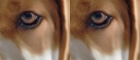

In [56]:
topil(torch.cat([img,img],dim=2))

In [79]:
s = 0

path = './inpainted/dogs/from_checkpoint_copy/000000/000000_0/'
imgs = np.array(os_sorted(bf.listdir(path)))

path_save = path + 'merged/'
if not os.path.exists(path_save):
        os.mkdir(path_save)

i_1 = []
i_2 = []
i_3 = []
imgs[:9]
imgs[9:18]
imgs[18:25]

for k in imgs[:9]:
    i_1.append(totens(Image.open(path+k)))
for k in imgs[9:18]:
    i_2.append(totens(Image.open(path+k)))

for k in imgs[18:25]:
    i_3.append(totens(Image.open(path+k)))
    
topil(torch.cat(i_1,dim=2)).save(path_save+str(s)+'1.png')
topil(torch.cat(i_2,dim=2)).save(path_save+str(s)+'2.png')
topil(torch.cat(i_3,dim=2)).save(path_save+str(s)+'3.png')

In [77]:
imgs[18:25]

array(['from_3240.png', 'from_3430.png', 'from_3620.png', 'from_3810.png',
       'from_4000.png', 'from_4190.png', 'from_4380.png'], dtype='<U13')

In [98]:
path = './inpainted/dogs/from_checkpoint_copy/'
folders = np.array(os_sorted(bf.listdir(path)))
folders = [path+i+'/' for i in folders]
folders = np.array([np.array([folders[j] + i +'/' for i in np.array(os_sorted(bf.listdir(folders[j])))[:3]]) for j in range(len(folders))]).flatten()

In [100]:
s=0
for path in folders:
    imgs = np.array(os_sorted(bf.listdir(path)))

    path_save ='./merged/'
    if not os.path.exists(path_save):
            os.mkdir(path_save)

    i_1 = []
    i_2 = []
    i_3 = []
    imgs[:9]
    imgs[9:18]
    imgs[18:25]

    for k in imgs[:9]:
        i_1.append(totens(Image.open(path+k)))
    for k in imgs[9:18]:
        i_2.append(totens(Image.open(path+k)))

    for k in imgs[18:25]:
        i_3.append(totens(Image.open(path+k)))

    topil(torch.cat(i_1,dim=2)).save(path_save+str(s)+'1.png')
    topil(torch.cat(i_2,dim=2)).save(path_save+str(s)+'2.png')
    topil(torch.cat(i_3,dim=2)).save(path_save+str(s)+'3.png')
    s+=1